# global variables

In [1]:
# data options
INPUT_IMAGE_SHAPE = (480, 640, 3)
NUMBER_OF_CLASSES = 4

# object detection options
STANDARD_DEVIATIONS_CENTROIDS_OFFSETS = (0.1, 0.1, 0.2, 0.2)

# tensorflow options
BATCH_SIZE = 16
SEED = 1993

# kaggle setup

## clone repository and setup

In [2]:
# check if repo folder exists, eventually delete it
%cd '/kaggle/working/'
import os
if os.path.exists('ssd-segmentation'):
    !rm -r 'ssd-segmentation'

# clone github repository
!git clone 'https://github.com/matteo-stat/ssd-segmentation.git'

# change working directory to cloned repository folder
%cd '/kaggle/working/ssd-segmentation'

# change branch
!git checkout 'models-construction'

# show working directory content
!ls

/kaggle/working
Cloning into 'ssd-segmentation'...
remote: Enumerating objects: 658, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 658 (delta 149), reused 181 (delta 88), pack-reused 406
Receiving objects: 100% (658/658), 2.56 MiB | 13.58 MiB/s, done.
Resolving deltas: 100% (405/405), done.
/kaggle/working/ssd-segmentation
Branch 'models-construction' set up to track remote branch 'models-construction' from 'origin'.
Switched to a new branch 'models-construction'
README.md				  reorganize-original-data.py
data					  requirements.txt
explore-aspect-ratio-ground-truth.py	  ssdseglib
object-detection-and-ssd-framework.ipynb  test.py
read-encode-and-decode-data.ipynb


# dependecies

In [3]:
import tensorflow as tf
tf.keras.saving.get_custom_objects().clear()
tf.random.set_seed(SEED)

import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import ssdseglib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# default bounding boxes

In [4]:
# create default bounding boxes
boxes_default = ssdseglib.boxes.DefaultBoundingBoxes(
    feature_maps_shapes=((30, 40), (15, 20), (8, 10), (4, 5)),
    centers_padding_from_borders_percentage=0.025,
    boxes_scales=(0.2, 0.9),
    additional_square_box=True,  
)

# rescale default bounding boxes to input image shape
boxes_default.rescale_boxes_coordinates(image_shape=INPUT_IMAGE_SHAPE[:2])

# data encoder

In [5]:
# create a data reader encoder
data_reader_encoder = ssdseglib.datacoder.DataEncoderDecoder(
    num_classes=NUMBER_OF_CLASSES,
    image_shape=INPUT_IMAGE_SHAPE[:2],
    xmin_boxes_default=boxes_default.get_boxes_coordinates_xmin(coordinates_style='ssd'),
    ymin_boxes_default=boxes_default.get_boxes_coordinates_ymin(coordinates_style='ssd'),
    xmax_boxes_default=boxes_default.get_boxes_coordinates_xmax(coordinates_style='ssd'),
    ymax_boxes_default=boxes_default.get_boxes_coordinates_ymax(coordinates_style='ssd'),
    iou_threshold=0.5,
    standard_deviations_centroids_offsets=STANDARD_DEVIATIONS_CENTROIDS_OFFSETS,
    augmentation_horizontal_flip=True
)

# input data

## load metadata

In [6]:
# training
with open('data/train.json', 'r') as f:
    path_images_train, path_masks_train, path_labels_boxes_train = map(list, zip(*json.load(f)))

# validation
with open('data/eval.json', 'r') as f:
    path_images_eval, path_masks_eval, path_labels_boxes_eval = map(list, zip(*json.load(f)))

# test
with open('data/test.json', 'r') as f:
    path_images_test, path_masks_test, path_labels_boxes_test = map(list, zip(*json.load(f)))

# replace local data directory with kaggle input directory    
path_images_train = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_images_train]
path_masks_train = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_masks_train]
path_labels_boxes_train = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_labels_boxes_train]

path_images_eval = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_images_eval]
path_masks_eval = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_masks_eval]
path_labels_boxes_eval = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_labels_boxes_eval]

path_images_test = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_images_test]
path_masks_test = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_masks_test]
path_labels_boxes_test = [path.replace('data/', '/kaggle/input/ssd-segmentation-data/data/') for path in path_labels_boxes_test]

## tensorflow datasets

In [7]:
# training
ds_train = (
    tf.data.Dataset.from_tensor_slices((path_images_train, path_masks_train, path_labels_boxes_train))
    .shuffle(buffer_size=len(path_images_train))
    .map(data_reader_encoder.read_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .map(ssdseglib.datacoder.augmentation_rgb_channels, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# validation
ds_eval = (
    tf.data.Dataset.from_tensor_slices((path_images_eval, path_masks_eval, path_labels_boxes_eval))
    .shuffle(buffer_size=len(path_images_eval))
    .map(data_reader_encoder.read_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .map(ssdseglib.datacoder.augmentation_rgb_channels, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# test
ds_test = (
    tf.data.Dataset.from_tensor_slices((path_images_test, path_masks_test, path_labels_boxes_test))
    .shuffle(buffer_size=len(path_images_test))
    .map(data_reader_encoder.read_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .map(ssdseglib.datacoder.augmentation_rgb_channels, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# weighted losses for model training

In [8]:
# weighted loss for semantic segmentation
dice_loss = ssdseglib.losses.dice(classes_weights=(0.175, 0.275, 0.275, 0.275))

# weighted metrics for model training

In [9]:
# weighted metrics for semantic segmentation
jaccard_iou_segmentation_masks_metric = ssdseglib.metrics.jaccard_iou_segmentation_masks(classes_weights=(0.175, 0.275, 0.275, 0.275))

# weighted metrics for boxes classification
categorical_accuracy_metric = ssdseglib.metrics.categorical_accuracy(classes_weights=(0.175, 0.275, 0.275, 0.275))

# weighted metrics for boxes regression
jaccard_iou_bounding_boxes_metric = ssdseglib.metrics.jaccard_iou_bounding_boxes(
    center_x_boxes_default=data_reader_encoder.center_x_boxes_default,
    center_y_boxes_default=data_reader_encoder.center_y_boxes_default,
    width_boxes_default=data_reader_encoder.width_boxes_default,
    height_boxes_default=data_reader_encoder.height_boxes_default,
    standard_deviations_centroids_offsets=STANDARD_DEVIATIONS_CENTROIDS_OFFSETS
)

# model

## architecture

In [10]:
# model builder
model_builder = ssdseglib.models.MobileNetV2SsdSegBuilder(
    input_image_shape=INPUT_IMAGE_SHAPE,
    number_of_boxes_per_point=[
        len(aspect_ratios) + (1 if boxes_default.additional_square_box else 0)
        for aspect_ratios in boxes_default.feature_maps_aspect_ratios
    ],
    number_of_classes=NUMBER_OF_CLASSES,
    center_x_boxes_default=boxes_default.get_boxes_coordinates_center_x(coordinates_style='ssd'),
    center_y_boxes_default=boxes_default.get_boxes_coordinates_center_y(coordinates_style='ssd'),
    width_boxes_default=boxes_default.get_boxes_coordinates_width(coordinates_style='ssd'),
    height_boxes_default=boxes_default.get_boxes_coordinates_height(coordinates_style='ssd'),
    standard_deviations_centroids_offsets=STANDARD_DEVIATIONS_CENTROIDS_OFFSETS
)

# model for training
model = model_builder.get_model_for_training()

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 backbone-input (InputLayer)    [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 backbone-input-rescaling (Resc  (None, 480, 640, 3)  0          ['backbone-input[0][0]']         
 aling)                                                                                           
                                                                                                  
 backbone-block0-expand-conv (C  (None, 240, 320, 32  864        ['backbone-input-rescaling[0][0]'
 onv2D)                         )                                ]                          

## optimizer

In [12]:
# learning rate schedule? maybe it's not a good idea with adam optimizer

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

## compile

In [13]:
# each ouput has its own loss and metrics
model.compile(
    optimizer=optimizer,
    loss={
        'output-mask': dice_loss,
        'output-labels': ssdseglib.losses.confidence_loss,
        'output-boxes': ssdseglib.losses.localization_loss
    },
    loss_weights={
        'output-mask': 1.0,
        'output-labels': 1.0,
        'output-boxes': 1.0
    },
    metrics={
        'output-mask': jaccard_iou_segmentation_masks_metric,
        'output-labels': categorical_accuracy_metric,
        'output-boxes': jaccard_iou_bounding_boxes_metric,
    }
)

## early stopping

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0025,
    patience=20,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=0,
)

## training model

In [15]:
# fit the model
history = model.fit(
    ds_train,
    validation_data=ds_eval,
    epochs=2,
    callbacks=[early_stopping]
)

Epoch 1/2
124/124 [==============================] - 168s 880ms/step - loss: 9.3036 - output-mask_loss: 0.7776 - output-labels_loss: 2.2939 - output-boxes_loss: 6.2322 - output-mask_jaccard_iou_segmentation_masks_metric: 0.1761 - output-labels_categorical_accuracy_metric: 0.8306 - output-boxes_jaccard_iou_bounding_boxes_metric: 0.0590 - val_loss: 9.9603 - val_output-mask_loss: 0.8366 - val_output-labels_loss: 1.3772 - val_output-boxes_loss: 7.7465 - val_output-mask_jaccard_iou_segmentation_masks_metric: 0.1325 - val_output-labels_categorical_accuracy_metric: 0.9855 - val_output-boxes_jaccard_iou_bounding_boxes_metric: 4.3051e-04
Epoch 2/2
124/124 [==============================] - 79s 634ms/step - loss: 5.6116 - output-mask_loss: 0.6224 - output-labels_loss: 1.2901 - output-boxes_loss: 3.6991 - output-mask_jaccard_iou_segmentation_masks_metric: 0.3328 - output-labels_categorical_accuracy_metric: 0.9967 - output-boxes_jaccard_iou_bounding_boxes_metric: 0.2808 - val_loss: 9.4452 - val_ou

## plot training history

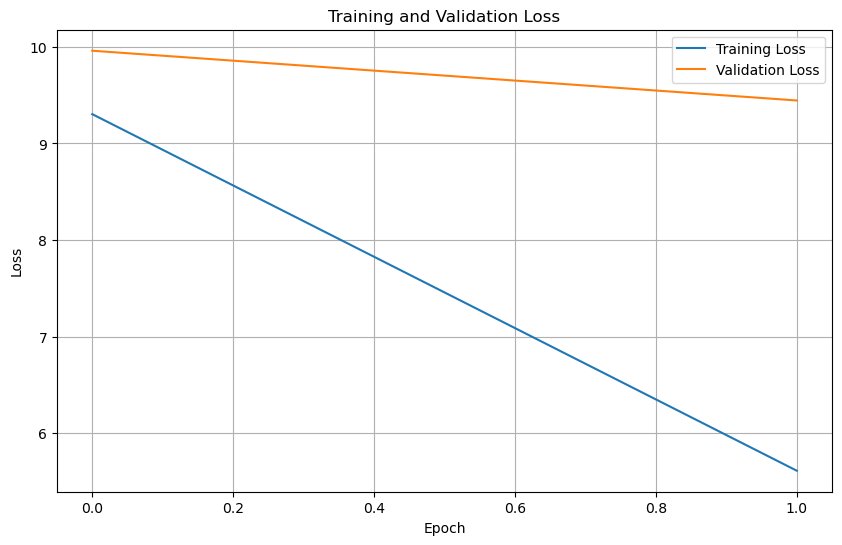

In [16]:
# plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## save weights

In [17]:
# model name
model_name = 'model'
model_pathfilename = f'/kaggle/working/{model_name}.keras'

In [18]:
# save model
model.save(model_pathfilename)

# eventually zip
#!zip '/kaggle/working/model_name.zip' '/kaggle/working/model_name.keras'

# predict

## inference model

In [19]:
# load trained model
model_trained = tf.keras.models.load_model(model_pathfilename, compile=False)

# transfer weights
model_inference = model_builder.get_model_for_inference(
    model_trained=model_trained,
    max_number_of_boxes_per_class=6,
    max_number_of_boxes_per_sample=20,
    boxes_iou_threshold=0.5,
    labels_probability_threshold=0.6
)

In [20]:
model_inference.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 backbone-input (InputLayer)    [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 backbone-input-rescaling (Resc  (None, 480, 640, 3)  0          ['backbone-input[0][0]']         
 aling)                                                                                           
                                                                                                  
 backbone-block0-expand-conv (C  (None, 240, 320, 32  864        ['backbone-input-rescaling[0][0]'
 onv2D)                         )                                ]                          

In [21]:
shuffled_indices = np.arange(len(path_images_test))
np.random.shuffle(shuffled_indices)

path_images_test = np.array(path_images_test)[shuffled_indices]
path_masks_test = np.array(path_masks_test)[shuffled_indices]
path_labels_boxes_test = np.array(path_labels_boxes_test)[shuffled_indices]

image = Image.open(path_images_test[0])
image_batch = np.array(image).astype(np.float32)
image_batch = np.expand_dims(image, axis=0)

output_mask, output_object_detection = model_inference(image_batch, training=False)

In [22]:
output_mask

<tf.Tensor: shape=(1, 480, 640, 4), dtype=float32, numpy=
array([[[[0.9318762 , 0.03495138, 0.01328516, 0.01988728],
         [0.9318762 , 0.03495138, 0.01328516, 0.01988728],
         [0.945633  , 0.0280405 , 0.01047595, 0.01585057],
         ...,
         [0.9464137 , 0.02641517, 0.01144494, 0.01572618],
         [0.932687  , 0.03290296, 0.01465566, 0.0197544 ],
         [0.932687  , 0.03290296, 0.01465566, 0.0197544 ]],

        [[0.9318762 , 0.03495138, 0.01328516, 0.01988728],
         [0.9318762 , 0.03495138, 0.01328516, 0.01988728],
         [0.945633  , 0.0280405 , 0.01047595, 0.01585057],
         ...,
         [0.9464137 , 0.02641517, 0.01144494, 0.01572618],
         [0.932687  , 0.03290296, 0.01465566, 0.0197544 ],
         [0.932687  , 0.03290296, 0.01465566, 0.0197544 ]],

        [[0.94859064, 0.02693784, 0.00945945, 0.01501207],
         [0.94859064, 0.02693784, 0.00945945, 0.01501207],
         [0.95951676, 0.02135571, 0.00731593, 0.01181154],
         ...,
         [0

In [23]:
output_object_detection

<tf.Tensor: shape=(0, 6), dtype=float32, numpy=array([], shape=(0, 6), dtype=float32)>